In [112]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [113]:
!pip install lightgbm

In [114]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [115]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [116]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [117]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [118]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloFinalLimpio.pkl") 
variables = open('./ModeloFinalLimpio.txt','r')
##ModeloV1T1

In [119]:
modelo

LGBMClassifier(colsample_bytree=0.84, force_col_wise='True',
               importance_type='gini', learning_rate=0.07, max_depth=20,
               min_child_weight=0.0026, n_estimators=520, num_leaves=30,
               objective='binary', scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


In [120]:
#variables = open('./ModeloFinal2.txt','r')
#var_input = variables.read()

In [121]:
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [122]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [123]:
testeo[var_input]

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,131.00000000000000000000,"2,659.00000000000000000000",0,1,1,1,0,2.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,True,False,0,0.02970297029702970160,0.63571428571428567622,0.05282575884621834583,0.21660649819494584567,0.00000000000000000000,0.17260273972602740988,0.29999999999999998890,0.58333333333333337034
1,109.00000000000000000000,"1,115.00000000000000000000",0,1,1,1,0,17.00000000000000000000,0,False,True,0.73118300535713409705,False,False,False,True,False,0,0.10891089108910891048,0.18392857142857144126,0.11973838671809491907,0.02166064981949458387,0.00000000000000000000,0.01643835616438356004,0.02857142857142857054,0.66666666666666662966
2,933.00000000000000000000,877.00000000000000000000,0,1,1,1,0,5.00000000000000000000,0,False,True,0.39062500000000000000,False,False,False,True,False,0,0.00990099009900990111,0.12321428571428572063,0.33724635250712731160,0.00902527075812274357,0.00000000000000000000,0.03013698630136986412,0.05238095238095238221,0.54166666666666662966
3,5.00000000000000000000,"4,494.00000000000000000000",0,2,2,2,0,12.00000000000000000000,0,False,True,2.43243243243243245644,False,False,False,True,False,0,0.43564356435643564192,0.73392857142857137465,0.28794231091732347405,0.16245487364620939119,0.00000000000000000000,0.02191780821917808236,0.03809523809523809867,0.37500000000000000000
4,56.00000000000000000000,751.00000000000000000000,0,1,1,1,0,2.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,True,False,0,0.02970297029702970160,0.83750000000000002220,0.23478115042763708642,0.72202166064981954108,0.00000000000000000000,0.16164383561643835829,0.28095238095238095344,0.50000000000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16724863,3.00000000000000000000,942.00000000000000000000,0,5,2,5,0,1.00000000000000000000,0,True,False,1.00000000000000000000,False,False,False,True,False,0,0.01980198019801980222,NaN,0.03907429146402817410,0.03610108303249097428,0.00000000000000000000,NaN,NaN,0.54166666666666662966
16724864,60.00000000000000000000,"2,028.00000000000000000000",0,1,1,1,0,8.00000000000000000000,0,False,True,1.01587301587301581662,False,False,False,True,False,0,0.50495049504950495489,0.98750000000000004441,0.23997987590139191472,0.14440433212996389711,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.50000000000000000000
16724865,0.00000000000000000000,"10,118.00000000000000000000",0,9,3,8,0,8.00000000000000000000,0,False,True,1.48411689961880566280,False,False,False,True,False,0,0.13861386138613862595,0.21249999999999999445,0.50025155123260101053,0.10541516245487364545,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.75000000000000000000
16724866,126.00000000000000000000,"3,154.00000000000000000000",0,1,1,1,0,3.00000000000000000000,0,True,True,1.01408479269994167282,False,False,False,True,False,0,0.12871287128712871617,0.61785714285714288252,0.13231594834814691675,0.04332129963898916775,0.00000000000000000000,0.03561643835616438297,0.06190476190476190688,0.54166666666666662966


In [124]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [125]:
#saco el punto de corte del primer centil para aplicarlo al test
corte2 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

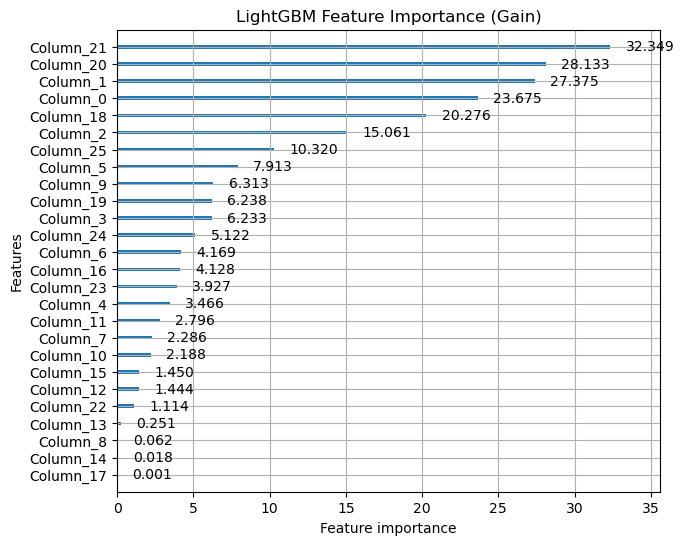

In [126]:
import lightgbm as lgb
lgb.plot_importance(modelo, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

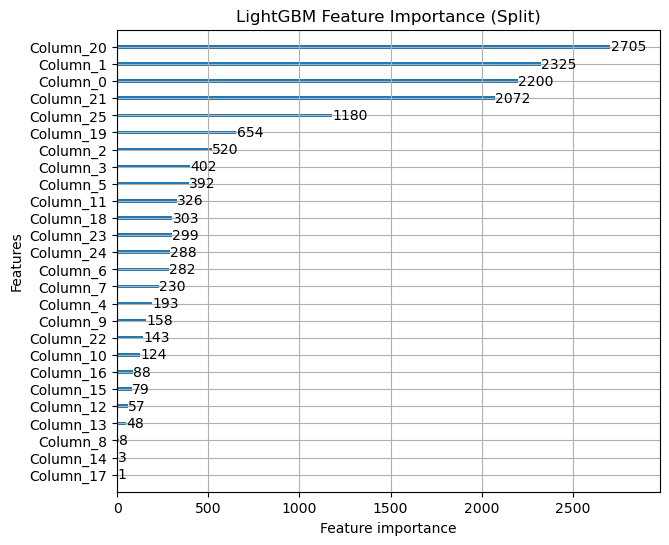

In [127]:
# Plot feature importance using Split
lgb.plot_importance(modelo, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [128]:
#Pongo el archivo q quiero testear
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")
#s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
#tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [129]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [130]:
testeo['target'].value_counts(dropna=False)

target
False    6837338
True          62
Name: count, dtype: int64

In [131]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [132]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [133]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,6837338,0
1,59,3


In [134]:
corte

4.21335052945521e-07

In [135]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,6833096,4242
1,48,14


In [136]:
#import seaborn as sns
#sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [137]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.3709677419354839


In [138]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,6822,16
2,6835,2
3,6833,5
4,6833,4
5,6833,4
...,...,...
996,6837,0
997,6837,0
998,6838,0


In [139]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000020501866270050 0.87290681569757966329
2            0.00000007922956406532 0.00000020496336115370
3            0.00000004502457360450 0.00000007921940952341
4            0.00000002987687817528 0.00000004502100845563
5            0.00000002174959235922 0.00000002987471000427
...                             ...                    ...
996          0.00000000000009279172 0.00000000000010685013
997          0.00000000000007798618 0.00000000000009279079
998          0.00000000000006077010 0.00000000000007798427
999          0.00000000000003862882 0.00000000000006076942
1000         0.00000000000000066370 0.00000000000003862803

[1000 rows x 2 columns]

In [140]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]
pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])
#pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
1,2141,12
2,1102,1
3,999,1


In [141]:
tes_corte.to_csv ('./Corte.csv')

In [142]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,961,874,734,790,1193,1308,978
2,900,919,780,754,1170,1279,1035
3,894,855,795,784,1113,1317,1080
4,842,840,811,724,1182,1438,1000
5,899,820,745,774,1121,1399,1079
6,914,841,771,738,1168,1388,1018
7,935,855,758,742,1164,1339,1044
8,897,883,755,816,1190,1293,1004
9,970,879,769,741,1089,1327,1062


In [143]:
#DECILES.to_csv ('./deciles.csv')

# Buckets para codificar Score

In [144]:
 Y_c['FRAUD_DECILE'].value_counts()

FRAUD_DECILE
181    6839
820    6839
828    6839
647    6839
168    6839
       ... 
646    6836
159    6836
791    6836
218    6836
611    6836
Name: count, Length: 1000, dtype: Int64

In [145]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets[['FRAUD_DECILE','min','max','final_score']].to_csv ('./Buckets.csv')

Y_c['score_rf2'] = 0
Y_c['score_rf2'] = Y_c['score_rf2'].astype(str) 
for i in range(Y_c.shape[0]):
    a = Buckets.loc[(Y_c.loc[i,'score_rf'] <= Buckets['max']) & (Y_c.loc[i,'score_rf'] >= Buckets['min']), 'final_score'] 
    Y_c.loc[i,'score_rf2'] = a.item()

In [146]:
#Y_c.loc[1,['score_rf2','FRAUD_DECILE']] 

In [147]:
Buckets[Buckets['FRAUD_DECILE']==644]

,FRAUD_DECILE,level_1,min,max,final_score
643,644,score_rf,0.00000000000483671320,0.00000000000486118642,0.35599999999999998312


## Curva ROC y FP

In [148]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [149]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [150]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [151]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
8.06450433433788
ROC FRAUD TESTEO:
0.5241935483870968


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.7305098619827889
Precision FRAUD TESTEO:
1.0
Recall FRAUD TESTEO:
0.04838709677419355


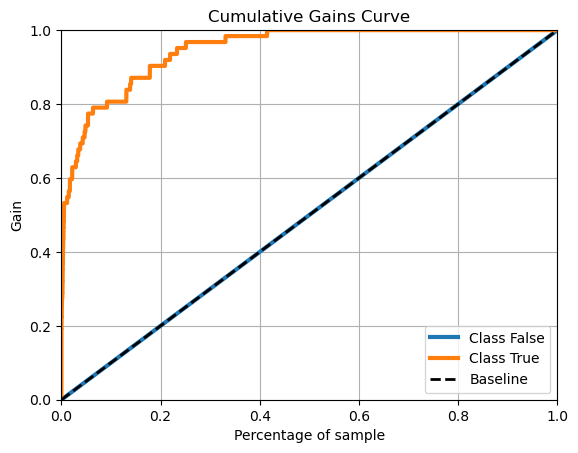

In [152]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


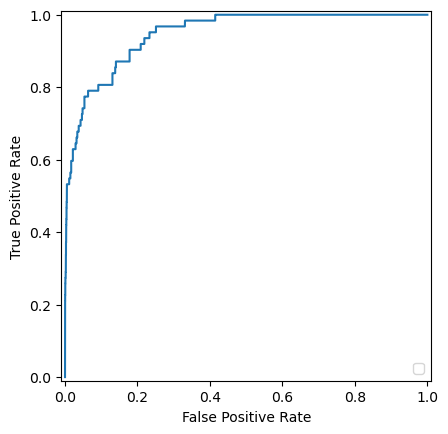

In [153]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

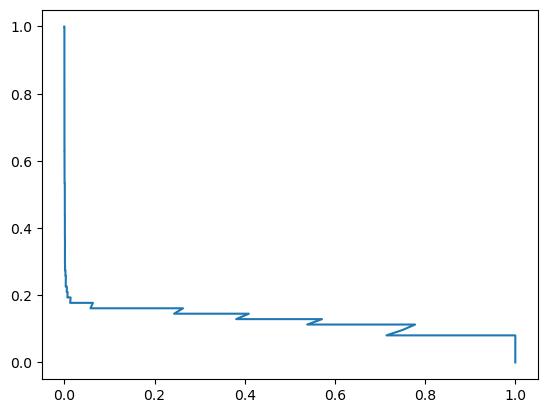

In [154]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(precision, recall)

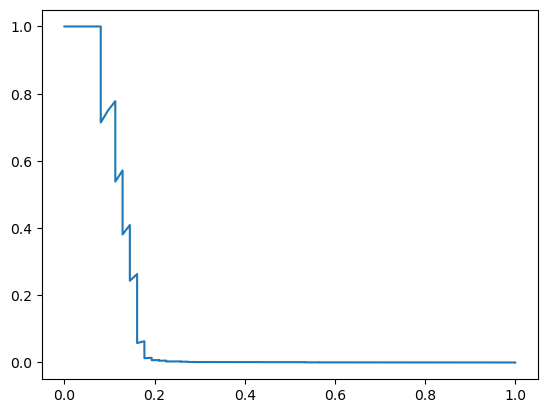

In [155]:
plt.plot(recall, precision)

## One given week

In [156]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
231933,A25718,47,2024-01-24 18:24:18.070,NY1546,NN,11306118,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX25,NY,65,NaN,NaN,USA,Real,NaN,8.00000000000000000000,0,40,CA,2,0,3,2,0,2,1,"1,500.00000000000000000000",0,1,18,True,False,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01331311088641725683,0.54840195669818159185,NaN,NaN,NaN,NaN,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
269827,A25718,46,2024-01-24 18:16:31.533,NY1546,NN,10303412,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX33,NY,65,210.00000000000000000000,34.00000000000000000000,USA,Real,"49,208.00000000000000000000",9.00000000000000000000,0,39,CA,1,1,2,2,0,1,2,"1,700.00000000000000000000",1,1,18,True,False,0.88235294117647056211,True,True,True,True,False,True,34.00000000000000000000,0,34.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.29329608938547485630,0.01331311088641725683,0.54840195669818159185,0.00000000000000000000,0.00000000000000000000,0.09315068493150685525,0.16190476190476191243,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
308307,A22792,11766,2024-01-19 17:47:25.867,NV0185,NN,11283276,980.00000000000000000000,1.00000000000000000000,MEX,MEX27,NV,583,NaN,NaN,USA,Real,NaN,30.00000000000000000000,0,2475,NV,3,0,1,1,0,3,1,980.00000000000000000000,0,1,17,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.10060667340748230547,0.35828927837614527041,NaN,NaN,NaN,NaN,0.70833333333333337034,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
468554,A25581,183,2024-01-07 19:55:34.963,SC0729,NN,11235795,980.00000000000000000000,1.00000000000000000000,MEX,MEX44,SC,66,NaN,NaN,USA,Real,NaN,28.00000000000000000000,0,173,SC,3,0,2,1,0,3,1,980.00000000000000000000,0,1,19,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01348163127738456410,0.35828927837614527041,NaN,NaN,NaN,NaN,0.79166666666666662966,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True
4

In [157]:
week_testigo = tes['date_receiver'].between('2024-01-01','2024-01-30')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(1972832, (1972832, 77), (1972832, 12))

In [158]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
1,14877,0
2,64369,0
3,53021,0
4,53556,0
5,82215,1
6,89445,0
7,75931,6
8,64412,0
9,49193,0


In [159]:
#Veo cuantos falsos positivos tengo con el punto de corte
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
1,22,0
2,56,0
3,41,0
4,47,0
5,82,0
6,68,0
7,44,5
8,74,0
9,46,0


In [160]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [161]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,37,20,28,29,22,25,18,31,24,28,25,19,18,13,20,23,23,22,19,26,19,29,17,22,17,30,21,19,25,28,23,15,24,18,14,21,25,20,22,27,26,15,21,18,14,23,18,19,18,14,20,23,21,22,23,17,14,23,15,22,21,22,19,26,10,14,17,32,24,22,17,15,22,14,19,17,24,18,15,14,17,24,31,20,16,23,18,23,17,25,22,20,18,18,27,22,20,23,20,20,18,20,17,18,20,21,19,27,30,19,21,16,24,22,17,19,14,22,11,16,21,23,20,16,26,18,21,14,18,26,15,20,13,19,14,14,23,14,22,13,22,13,19,25,20,20,17,15,20,24,13,23,18,21,19,19,19,19,15,18,18,16,21,9,15,19,16,14,20,23,20,14,21,16,22,21,18,16,19,18,13,21,29,22,14,19,19,25,25,19,18,24,16,16,11,17,31,13,20,16,16,17,17,25,14,24,16,13,15,28,20,18,18,25,19,11,28,24,19,24,10,17,16,17,16,19,21,16,13,20,16,18,17,17,17,24,13,20,20,22,17,18,12,13,13,13,19,27,16,20,...,16,16,16,14,14,12,15,19,13,5,14,8,12,14,13,11,10,12,7,15,12,10,15,14,12,11,11,14,15,10,9,12,6,11,6,13,11,12,6,9,8,10,16,14,14,12,7,10,12,9,10,10,7,8,17,5,10,12,6,7,10,9,13,7,8,12,11,10,6,4,13,5,12,8,4,14,11,10,13,11,7,14,12,13,9,11,10,9,12,9,6,13,6,18,12,4,9,10,6,10,8,9,7,10,9,10,10,9,8,10,8,11,13,15,6,8,11,6,8,8,9,12,9,8,9,7,15,9,9,10,19,12,7,9,8,10,6,8,5,8,8,11,10,8,11,15,10,8,10,12,8,5,8,10,10,5,13,10,9,12,7,7,13,6,9,5,12,10,5,16,11,7,18,13,9,3,8,15,11,6,8,11,7,15,10,11,10,7,7,10,7,9,9,10,11,13,7,13,9,12,7,12,14,11,6,9,8,7,9,11,9,16,10,3,7,10,5,7,9,11,6,14,7,9,10,13,14,10,7,5,12,10,5,6,13,9,17,13,4,14,14,8,7,10,9,12,7,4,10,5
2,98,120,112,95,84,116,103,97,87,79,91,95,97,122,93,85,103,96,90,91,91,83,92,93,116,97,94,100,95,91,84,90,77,87,83,99,117,85,100,102,73,90,101,88,85,80,82,79,88,101,104,84,91,82,96,95,

In [162]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,3,4,5,38,64,139
date_receiver,,,,,,,,
5,0,0,0,0,0,0,0,1
7,5,0,0,0,0,0,1,0
14,1,1,0,0,0,1,0,0
19,0,1,2,1,1,0,0,0
21,3,0,0,0,1,0,0,0
24,3,0,0,0,0,0,0,0


In [163]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
231933,24,Real,1
269827,24,Real,1
308307,19,Real,5
468554,7,Real,1
475176,5,Real,139
507041,24,Real,1
522317,21,Real,1
526070,14,Real,38
675600,21,Real,1
712534,21,Real,5


# Analisis extra por cantidad FP

In [164]:
testeo.loc[(testeo['id_receiver'] ==30890) & (testeo['id_branch'] =='A14536')] 
#testeo['id_branch'] =='A14536'

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4870507,A14536,30890,2024-03-20 12:42:15.783,MA0108,NN,5717054,"1,050.50000000000000000000",28.00000000000000000000,BRA,BRA2,MA,2751,888.00000000000000000000,35.00000000000000000000,USA,None,"50,478.00000000000000000000",24.00000000000000000000,0,1116,MA,0,0,2,1,0,0,4,"2,492.06999999999970896170",0,3,12,False,True,0.42153711573109908795,False,False,False,False,False,True,35.00000000000000000000,0,35.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.28421052631578946901,1.00000000000000000000,0.46595888102460397695,0.38406417034095979846,0.00000000000000000000,0.00000000000000000000,0.09589041095890410427,0.16666666666666665741,0.50000000000000000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


<Axes: xlabel='date_receiver', ylabel='Count'>

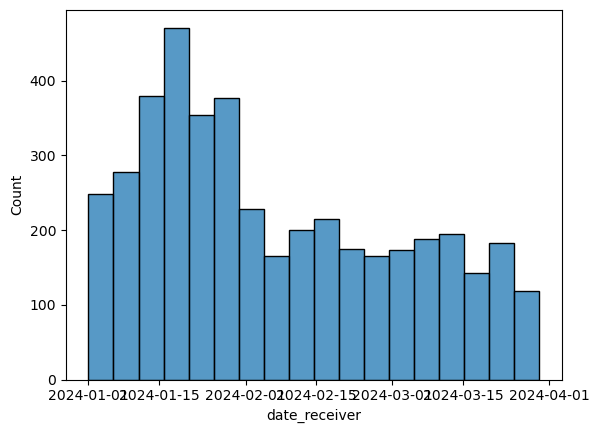

In [165]:
import seaborn as sns
sns.histplot(data = tes_corte['date_receiver'].dt.floor('d'))

<Axes: xlabel='date_receiver', ylabel='Count'>

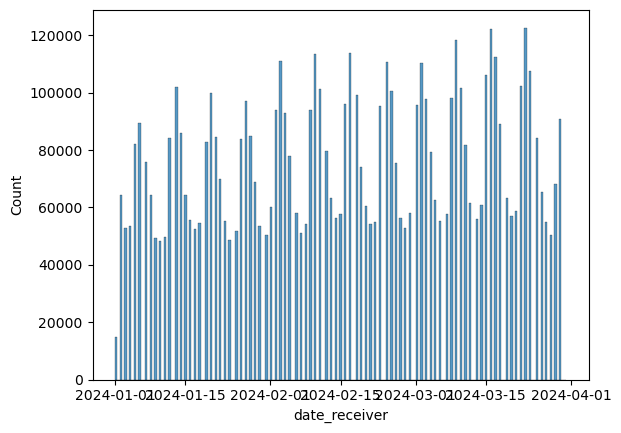

In [166]:
sns.histplot(data = testeo['date_receiver'].dt.floor('d'))

In [167]:

Alertas_2024 = pd.crosstab(tes_corte['date_receiver'].dt.floor('d'), Y_c_corte['target'])
Alertas_2024.to_csv ('./alertas2024.csv')

In [168]:
testeo[testeo['mes']==1].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,receiver_transaction_count,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,076,906.00000000000000000000",2076906,"2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,874.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000"
mean,"67,332.80096403014613315463",2024-01-17 03:25:09.707793152,"8,267,104.98367908783257007599",457.34215281105622352698,1.01808555611086881676,"1,599.41525134021480880619",555.94958481402181860176,30.71975416800350089375,"44,240.69602518725150730461",111.74940993050131510245,0.00000000000000000000,"3,671.45134348882402264280",0.09055296676883788087,0.01347774044660663556,4.14846555405011141460,1.91383047668021566423,2.69588031427517682559,0.09084282100393566151,8.39999065918245690909,461.67398417969280899342,0.00008377846662294778,1.00000000000000000000,15.26093381212245603251,0.98341650062590824088,23.58870987014347164745,0.01139531591704198536,19.65989884624517358702,0.02492601976208841386,94.08835013212427611506,24.80822175522662575986,0.00019037427485125020,0.63292275709399026251,0.27129709832035037165,0.16425209527904952034,0.03266956601809870020,0.01722793177446295051,0.06462660238395470658,0.09361856593450078312,0.63587224217176885332
min,1.00000000000000000000,2024-01-01 03:00:23.573000,9.00000000000000000000,0.00000000000000000000,1.00000000000000000000,-19.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,1.00000000000000000000,3.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000

In [169]:
testeo[testeo['mes']==3].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,receiver_transaction_count,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,493,885.00000000000000000000",2493885,"2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,488,376.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000"
mean,"67,147.78369291286799125373",2024-03-15 19:30:47.806508544,"8,397,131.44546440616250038147",440.77123431790164431732,14.01989386038249563171,"1,585.12772240901244913402",578.95790993637422161555,33.05045768722315813193,"47,598.26427709477866301313",96.54369596877641868105,0.00000000000000000000,"3,485.99444360906772999442",0.08959795660184811938,0.01594139264641312656,4.45229310894447838365,2.00665868714876571843,2.91195544301361142203,0.08983573821567554518,7.95960038253568225031,438.92972999902144692896,0.00008500792939530091,3.00000000000000000000,15.48751526233166408986,1.00616651224200026604,24.07418810623104832302,0.01389719253293556119,19.86344083714932295948,0.02840146999560926033,99.13195137575357307469,26.57468169255313483745,0.13316021092856278329,0.64363202833923516266,0.26877491640136536022,0.15867546247265090775,0.03442081644991443895,0.01845464006427301878,0.06595667974309876724,0.09458781351023486106,0.64531313593048655886
min,1.00000000000000000000,2024-03-01 03:00:17.187000,9.00000000000000000000,0.73999999999999999112,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.91266666666666662611,0.00000000000000000000,3.00000000000000000000,3.00000000000000000000,0.00066489067717885424,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00235928547354229872,0

for var in var_input:
    sns.histplot(data = tes_corte, x=var, hue = 'mes')
    plt.show()

In [170]:
week_fraude = tes['date_receiver'].between('2024-03-21','2024-03-22')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
X_fraude[Y_c_fraude['pred_corte']==True].sort_values(by=['id_branch'])

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4633941,A05945,70909,2024-03-21 20:53:30.157,AL0152,NN,5704968,"1,878.00000000000000000000",1.00000000000000000000,MEX,MEX27,AL,4957,"1,055.00000000000000000000",14.00000000000000000000,USA,None,"20,178.00000000000000000000",4.00000000000000000000,0,2445,AL,9,0,2,2,0,9,6,"1,546.27499999999986357579",0,3,20,True,True,1.21453169714313435890,False,True,True,False,False,True,14.00000000000000000000,0,14.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.83771486349848334196,0.68659924978612330015,0.00000000000000000000,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.83333333333333337034,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4658302,A05945,70912,2024-03-21 21:29:02.273,AL0152,NN,6915613,"1,878.00000000000000000000",1.00000000000000000000,MEX,MEX15,AL,4957,"1,152.00000000000000000000",10.00000000000000000000,USA,None,"15,071.00000000000000000000",28.00000000000000000000,0,2446,AL,9,0,5,1,0,9,17,656.37529411764671749552,0,3,21,True,True,2.86116801901351403004,False,True,True,False,False,True,10.00000000000000000000,0,10.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.83771486349848334196,0.68659924978612330015,0.00000000000000000000,0.00000000000000000000,0.02739726027397260122,0.04761904761904761640,0.87500000000000000000,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
6454859,A08570,85774,2024-03-21 13:17:10.250,TX0358,NN,3029484,610.00000000000000000000,1.00000000000000000000,MEX,MEX25,TX,4091,"1,082.00000000000000000000",16.00000000000000000000,USA,None,"22,611.00000000000000000000",30.00000000000000000000,0,1233,TX,3,0,2,1,2,3,3,637.00000000000000000000,0,3,13,True,True,0.95761381475667195495,False,True,True,False,True,False,16.00000000000000000000,0,16.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.69177620492079539005,0.22301679572392715811,0.00000000000000000000,0.00000000000000000000,0.04383561643835616473,0.07619047619047619735,0.54166666666666662966,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5839414,A15778,73375,2024-03-21 13:

In [171]:
#Y_c[tes['id_barnch'].str.contains('A24793')].sort_values(by=['id_receiver'])
testeo.loc[(testeo['id_receiver'] ==5619) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target


In [172]:

pd.crosstab(testeo.loc[Y_c['target']==True,'date_receiver'], Y_c.loc[Y_c['target']==True,'pred_corte'])


pred_corte,False,True
date_receiver,,
2024-01-05 15:45:55.033,1,0
2024-01-07 18:52:26.650,1,0
2024-01-07 19:07:52.540,0,2
2024-01-07 19:27:44.750,0,1
2024-01-07 19:55:34.963,0,1
2024-01-07 20:11:15.780,0,1
2024-01-14 15:09:23.963,1,0
2024-01-14 15:27:10.183,1,0
2024-01-14 16:29:44.087,0,1
